# 1-D Trajectory Matrix Completion with Velocity Constraint

In this notebook, we will run a 1D algorithm similar to LADMAP to impute 2 matrices that misses data at random position: one is the matrix of position, while the other is the matrix of velocity.

Then, if it is possible, we try to compare the performance, between imputing two matrices independently, and with other commonly used methods.

Candidates for comparison:
<ol>
<li>SciPy's interpolation methods: include Spline fitting</li>
<li>Fourier/Wavelet smoothing</li>
</ol>

In [184]:
import numpy as np
np.random.seed(6969)
from matplotlib import pyplot as plt

from scipy.stats import expon, norm

In [185]:
def plot_expon_pdf(loc, scale):
    x = np.linspace(expon.ppf(0.01, loc=loc, scale=scale), expon.ppf(0.99, loc=loc, scale=scale), 100)
    plt.plot(x, expon.pdf(x, loc=loc, scale=scale), label='expon pdf')

In [186]:
def sample_expon(loc, scale):
    return expon.rvs(loc=loc, scale=scale, size=1).item()

In [187]:
def sample_norm(mean, sd):
    return norm.rvs(loc=mean, scale=sd, size=1).item()

In [188]:
sample_norm(mean=15, sd=3)

9.713646735503456

Generate the trajectory matrix and the velocity matrix: we generate the velocity matrix first, then integrate the velocity to get the position:

In [189]:
num_of_traces = 200
length_of_traces = 250
rise_period_scale = 0.1 * length_of_traces
transition_period_scale = 0.2*length_of_traces

v_mat = np.zeros((num_of_traces, length_of_traces))

for trace in range(num_of_traces):
    t = 0 # time index
    p = 0 # period index
    while t < length_of_traces:
        if p == 0:
            period_length = int(sample_expon(loc=0, scale=rise_period_scale))
            while period_length < 5:
                period_length = int(sample_expon(loc=0, scale=rise_period_scale))
        else:
            period_length = int(sample_expon(loc=0, scale=transition_period_scale))

        if t + period_length < length_of_traces:
            if p == 0: # this is a rise period 
                rise_to_value = sample_norm(mean=15, sd=1)
                if period_length == 1:
                    mt = np.arange(period_length) * rise_to_value
                else:
                    mt = np.arange(period_length) / (period_length - 1) * rise_to_value
                v_mat[trace,:period_length] = mt
            else: # this is a transition period
                hold_value = sample_norm(mean=15, sd=2)
                mt = np.ones((period_length,)) * hold_value
                v_mat[trace,t:t+period_length] = mt
            p+=1
            t = t + period_length
        else:
            # this is a fall period
            period_length = length_of_traces - t
            if period_length == 1:
                mt = v_mat[trace,t-1] - np.arange(period_length) * v_mat[trace,t-1]
            else:
                mt = v_mat[trace,t-1] - np.arange(period_length) / (period_length - 1) * v_mat[trace,t-1]
            v_mat[trace,t:t+period_length] = mt
            v_mat[trace,t:t+period_length] = mt
            t = length_of_traces + 1 # ensure breaking the loop

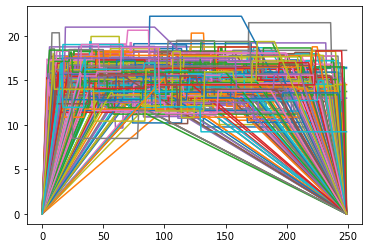

In [190]:
for i in range(num_of_traces):
    plt.plot(v_mat[i,:])

In [191]:
x_mat = np.cumsum(v_mat, axis=1)

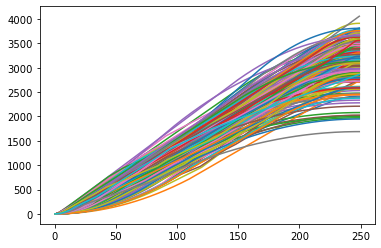

In [192]:
for i in range(num_of_traces):
    plt.plot(x_mat[i,:])

In [193]:
D = -np.eye(x_mat.shape[1])
for i in range(x_mat.shape[1]-1):
    D[i+1,i] = 1
# D = np.concatenate([np.zeros((D.shape[0],)),D])

In [194]:
v_mat = x_mat @ D

Now we are going to mask several elements of the matrices $V$ and $X$, which simulate information corruption due to CAM/ADS-B packet loss/corruption. The goal is to impute these entries.

In what follows, we use Bernoulli distribution for the masking of values. One may consider other distributions, such as Gaussian. The mask indices are distributed independently across examples, and we also assume independence between $X$ and $V$.

In ADS-B data, the $X$ matrix is usually masked a lot more than $V$. The independence hypothesis seems to match up with ADS-B system design, if the aircraft is well within coverage. But mask indices due to lack of coverage may create correlation between examples, entries, and even between $X$ and $V$. In this case, one may 

In [195]:
v_mat_nan = np.empty_like(v_mat)
x_mat_nan = np.empty_like(x_mat)
for trace in range(num_of_traces):
    row_index_of_mask = np.random.uniform(high=3, size=(length_of_traces-1,)) # 1/3 missing
    row = v_mat[trace,:-1].copy()
    row[row_index_of_mask < 1] = np.nan
    v_mat_nan[trace,:-1] = row

    row_index_of_mask = np.random.uniform(high=3, size=(length_of_traces,)) # 1/3 missing
    row = x_mat[trace,:].copy()
    row[row_index_of_mask < 1] = np.nan
    x_mat_nan[trace,:] = row    

In [196]:
from numpy import ma
v_mat_maskarray = ma.masked_invalid(v_mat_nan)
v_mat_maskarray = ma.masked_invalid(x_mat_nan)

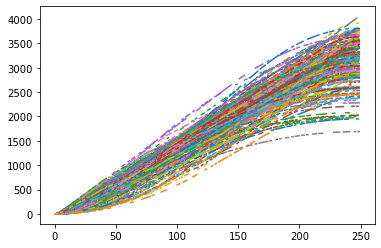

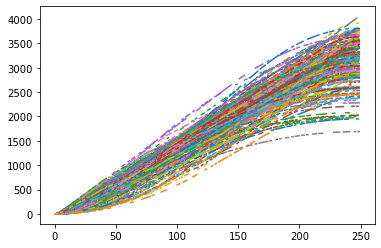

In [197]:
for i in range(num_of_traces):
    plt.plot(v_mat_maskarray[i,:])

plt.figure()
for i in range(num_of_traces):
    plt.plot(v_mat_maskarray[i,:])

Now let's try to recover the two original matrices:

In [198]:
# Hyper-parameters
beta = 1 # the trade-off between V and X. =1 because X and V obeys the same masking amount
mu = 1
max_iters = 1

# Initial variables
x_hat = np.zeros_like(x_mat) # primal
v_hat = np.zeros_like(v_mat) # primal
m1 = np.zeros_like(x_mat) # dual 
m2 = np.zeros_like(v_mat) # dual
m3 = np.zeros_like(v_mat) # dual

In [199]:
v_mat_masked_to_zero = np.nan_to_num(v_mat_nan)

In [209]:
v_mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [1, 0, 1, ..., 0, 0, 1]])

In [200]:
v_mask = ma.getmask(v_mat_maskarray).astype(int)

The SVT algorithm

In [201]:
from matrix_completion import svt_solve

In [204]:
vx = .5 * (x_hat @ D + 1/mu * m2 + v_mat_masked_to_zero - 1/mu * m3)
v_hat_new = svt_solve(vx, v_mask)

/Users/thinhhoang/miniforge3/envs/liberty/lib/python3.8/site-packages/matrix_completion/svt_solver.py:91: RuntimeWarning: invalid value encountered in double_scalars
  recon_error = np.linalg.norm(mask * (X - A)) / np.linalg.norm(mask * A)


In [205]:
vx

array([[2.99256672e-001, 0.00000000e+000, 8.97770015e-001, ...,
        3.26146960e-001, 0.00000000e+000, 7.89897903e+077],
       [0.00000000e+000, 4.84256417e-001, 7.26384625e-001, ...,
        0.00000000e+000, 0.00000000e+000, 1.22807467e+165],
       [1.07076778e+000, 0.00000000e+000, 0.00000000e+000, ...,
        8.73825047e-002, 0.00000000e+000, 3.04709693e-061],
       ...,
       [3.24055313e-001, 6.48110625e-001, 9.72165938e-001, ...,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       [9.14062729e-001, 1.82812546e+000, 2.74218819e+000, ...,
        1.64195290e-001, 0.00000000e+000, 0.00000000e+000],
       [5.03697362e-001, 0.00000000e+000, 0.00000000e+000, ...,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000]])